## Problem Statement:
- Detection of Pneumonia from chest X-ray image.

## Data Source:
- Data has been taken from Kaggle.
- It contains 5800 images of Pneumonia and Normal combined.
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

## Importing Libraries

In [2]:
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras.models  import Sequential, load_model,save_model 
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16


## Loading Data and Augmentation using Tensorflow

In [3]:
bs = 32
gen = ImageDataGenerator(rescale = 1/255, horizontal_flip = True, vertical_flip = True,rotation_range = 60, 
                        zoom_range = 0.2, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2,
                                         brightness_range = [0.6, 0.9])
gen_test = ImageDataGenerator(rescale = 1/255)

train_data = gen.flow_from_directory("chest_xray/train/", batch_size = bs, class_mode = 'binary')
val_data = gen_test.flow_from_directory("chest_xray/val/", batch_size = bs, class_mode = 'binary')
test_data = gen_test.flow_from_directory("chest_xray/test/", batch_size = bs, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Creating dictionary of the labels for later use

In [4]:
lab = train_data.class_indices
rev_lab = dict(zip(lab.values(),lab.keys()))
lab,rev_lab

({'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'})

## Sample Images

In [5]:
samp_x, samp_y = next(val_data)
samp_x.shape, samp_y.shape

((32, 256, 256, 3), (32,))

C:\Users\abba\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


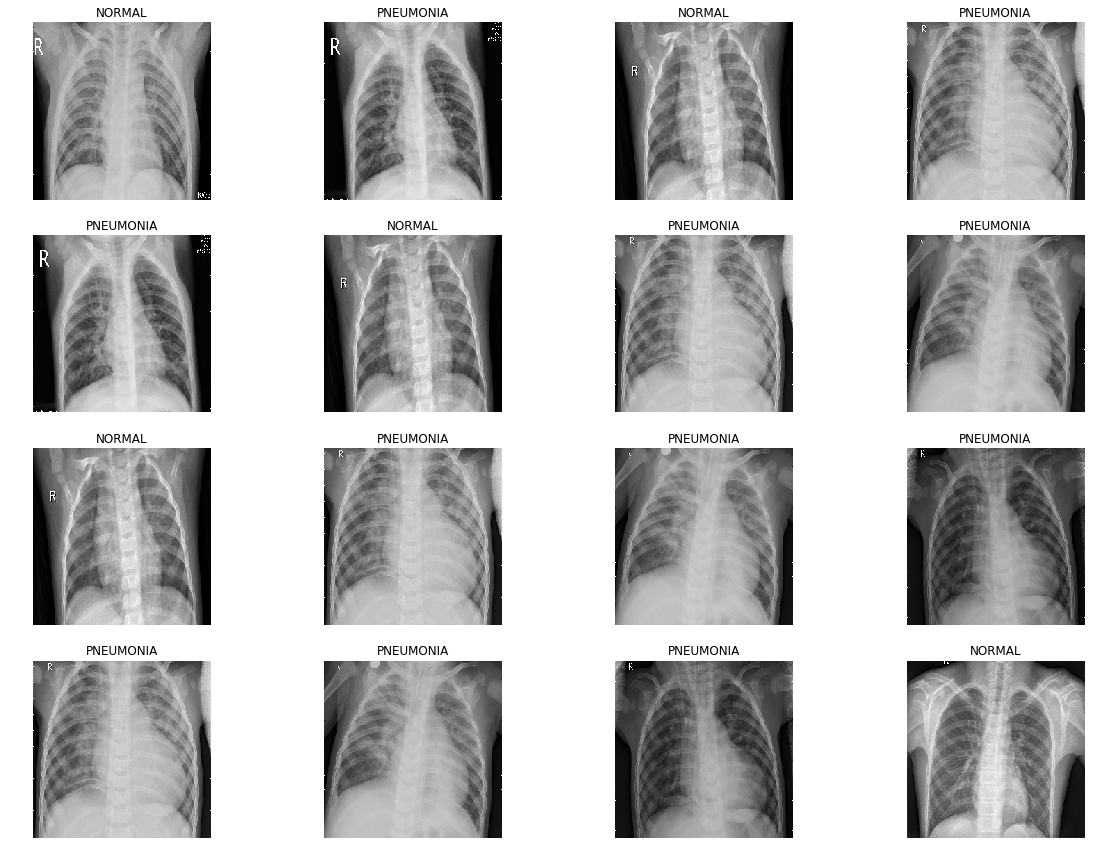

In [6]:
f, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        n = np.random.randint(0, len(samp_x[i+j]))
        ax[i, j].imshow(samp_x[i+j])
        ax[i, j].set_title(rev_lab.get(samp_y[i+j]))
        ax[i, j].axis('off')
f.set_figheight(15)
f.set_figwidth(20)
f.show()

###  Sample Image 



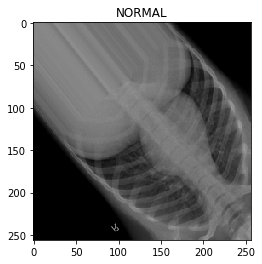

In [7]:
n = np.random.randint(0,len(train_data),2)[0]
plt.imshow(train_data[n][0][0])
plt.title(rev_lab.get(train_data[n][1][0]))
plt.show()

## Data Analysis

train data


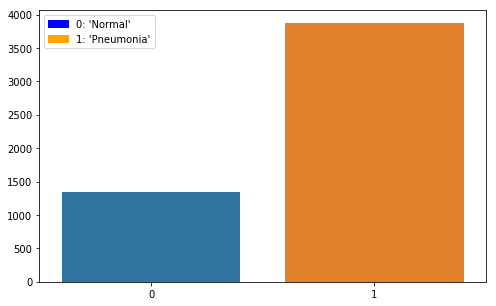

val data


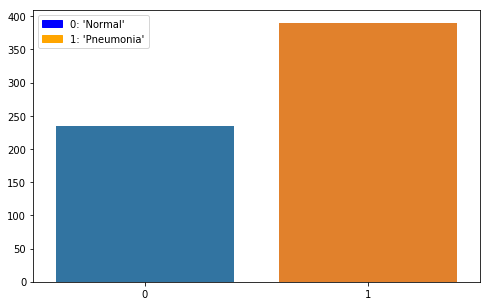

test data


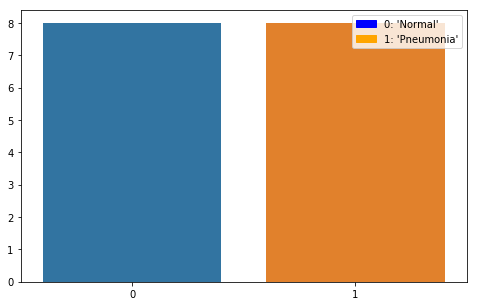

In [8]:
#plote GRAPH OF NORMAL AND PNEUMONIA FOR TRAIN DATA,TEST DATA ,VAL DATA
for obj in [train_data,val_data,test_data]:
    name=obj.directory.split('/')[-2]
    name=f'{name} data'
    print(name)
    count=Counter(obj.classes)
    plt.figure(figsize = (8, 5))
    sb.barplot(x=list(count.keys()), y=list(count.values()))
    blue_patch = mpatches.Patch(color='blue', label="0: 'Normal'")
    orange_patch = mpatches.Patch(color='orange', label="1: 'Pneumonia'")
    plt.legend(handles=[blue_patch, orange_patch])
    plt.show()
    
    print('=='*35)

## VGG16 Architecture:
- VGG16 with 2 more Dense layers.
- Dropout for avoiding overfitting.
- Loss function Binary Cross Entropy and accuracy as metrics

In [9]:
 #model=load_model('model.h5')

In [9]:
vgg=VGG16(include_top=False,input_shape=(256, 256, 3))
vgg.trainable=False
model=Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dropout(0.9))

model.add(Dense (32,activation ='relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
model.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1048608   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,763,329
Trainable params: 1,048,641
Non-trainable params: 14,714,688
_________________________________________________________________


## Sample prediction on untrained model

In [10]:
x,y=next(test_data)
predict=model.predict(x)

In [12]:
model.evaluate(test_data)

1/1 [==============================] - 0s 0s/step - loss: 0.8205 - accuracy: 0.5000


[0.8205402493476868, 0.5]

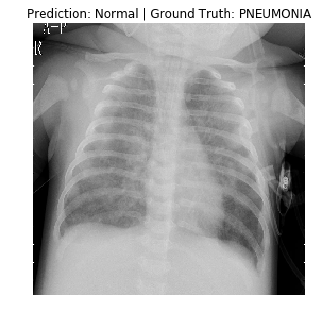

In [13]:
idx = np.random.randint(0, len(x))
plt.figure(figsize = (8, 5))
if predict[idx] > 0.9:
    pred = "Pneumonia"
else:
    pred = "Normal"
plt.imshow(x[idx])
plt.axis('off')
plt.title('Prediction: '+pred+' | '+'Ground Truth: ' + rev_lab.get(y[idx]))
plt.show()

## Model training

In [14]:
# check = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only = True, verbose = True)
# model.fit(train_data, epochs = 100 ,validation_data = val_data, callbacks = [check])

Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.7828
Epoch 00001: val_loss improved from inf to 0.36788, saving model to model.h5
163/163 [==============================] - 102s 626ms/step - loss: 0.4665 - accuracy: 0.7828 - val_loss: 0.3679 - val_accuracy: 0.8638
Epoch 2/100
163/163 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8372
Epoch 00002: val_loss did not improve from 0.36788
163/163 [==============================] - 101s 619ms/step - loss: 0.3560 - accuracy: 0.8372 - val_loss: 0.3884 - val_accuracy: 0.8413
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8535
Epoch 00003: val_loss improved from 0.36788 to 0.36030, saving model to model.h5
163/163 [==============================] - 101s 623ms/step - loss: 0.3413 - accuracy: 0.8535 - val_loss: 0.3603 - val_accuracy: 0.8638
Epoch 4/100
163/163 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.850

KeyboardInterrupt: 

## Training Analysis

In [12]:
history = model.history.history
plt.figure(figsize = (8, 5))
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'], label = 'Train Loss')
plt.plot(epochs, history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs Vs Loss')
plt.legend()
plt.show()

KeyError: 'loss'

<Figure size 576x360 with 0 Axes>

In [13]:
plt.figure(figsize = (8, 5))
epochs = list(range(len(history['accuracy'])))
plt.plot(epochs, history['accuracy'], label = 'Train Accuracy')
plt.plot(epochs, history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs Vs Accuracy')
plt.legend()
plt.show()

KeyError: 'accuracy'

<Figure size 576x360 with 0 Axes>

## Sample Prediction on trained model

In [15]:
 model=load_model('model.h5')

In [27]:
predict = model.predict(x)

In [28]:
model.evaluate(test_data)

1/1 [==============================] - 0s 0s/step - loss: 0.3246 - accuracy: 0.9375


[0.32460299134254456, 0.9375]

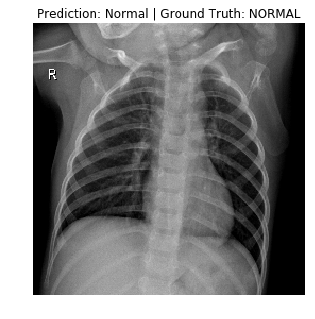

In [32]:
plt.figure(figsize = (8, 5))
if predict[idx] > 0.9:
    pred = "Pneumonia"
else:
    pred = "Normal"
plt.imshow(x[idx])
plt.axis('off')
plt.title('Prediction: '+pred+' | '+'Ground Truth: ' + rev_lab.get(y[idx]))
plt.show()

In [1]:
x[idx]


NameError: name 'x' is not defined